<a href="https://colab.research.google.com/github/juancn95/saturdaysAI_titanic_challenge/blob/pdt_1/SaturdaysAI_titanic_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **El desafío del Titanic**
---

## **Visión general**
El hundimiento del Titanic es uno de los naufragios más infames de la historia. El 15 de abril de 1992, durante su viaje de inauguración, el considerado "no hundible" RMS Titanic, se hundió luego de colisionar con un iceberg. Desafortunadamente, no hubieron suficientes salvavidas para cada uno de los pasajeros a bordo, resultando en la muerte de más de 1502 personas, entre pasajeros y tripulación, para un total de 2224. 

Aunque habían elementos de buena suerte involucrados en la supervivencia, parece que ciertos grupos de personas tuvieron mayor probabilidad de sobrevivir que otras. 

En esta competencia, usando los datos de los pasajeros, tales como nombre, género, clase socio-económica, entre otros; se deberá construir un modelo predictivo que responda a la siguiente pregunta: ¿Cuáles fueron los grupos de personas con mayor probabilidad de sobrevivir? 

## **Objetivo**
- Predecir si cada uno de los pasajeros sobrevivió (1) o  no (0), tras el hundimiento del barco Titanic

## **Métrica**

La puntuación del modelo será el **porcentaje de pasajeros correctamente predecidos**, conocido también como **precisión**.

## **Formato del archivo de entrega**
El formato será un archivo de extensión `.csv` con 418 entradas con su correspondiente fila de encabezado, y solo deberá contener las columnas `PassengerID` y `Survived`. Si el archivo tiene una columna o fila extra, se remitirá un error. 

`PassengerID`: Ordenado en cualquier orden, sea ascendente o descendente. 

`Survived`: Contiene la **predicción binaria**: 1 para sobrevivió, 0 para fallecido.



# **Inicio**

## **Depencias**
**Manipulación de datos**: `pandas` `numpy` `scikit-learn`

**Visualización de datos**: `matplotlib` `seaborn` 

**Estadísticos**: `phik`<font size="2"><sup>1</sup></font> 

<font size="2"><b>[Phik](https://arxiv.org/abs/1811.11440) </b>
<sup>1</sup> es un coeficiente de correlación basado en varios refinamientos a la prueba de hipótesis de Pearson de independencia de dos variables: categóricas, ordinales y de intervalo.</font>

In [0]:
!pip install phik
! pip3 install -U cmocean

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import resources, report

from scipy import stats
from scipy.stats import chi2, chi2_contingency

from math import sqrt

## **Carga de datos desde AWS**


In [0]:
df = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/train.csv')
df_test = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/test.csv')
df_sub = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/gender_submission.csv')

In [0]:
df2 = pd.merge(df_test, df_sub)

# **EDA**

# **Paquete de trabajo No. 1**

**Entregable**
* Objeto `DataFrame` con los pares de variables asignados **mejorados**
---
<p>
<font size="2.2">
<b>Nota:</b> Este entrable debe tener como fin, incrementar la relevancia, como sea posible, de todos los pares de variables con respecto a la variable predictiva.<font>
</p>
<p>
<font size="2.2">
<b>Claves:</b>La métrica usada para cuantificar la correlación o relación entre dos pares de variables dependerá su tipo, sea continuo-continuo, categórico-categórico o categórico-continuo.<font>
</p>



## **nameSex**

In [0]:
# Escriba el código del par de variables 'nameSex' aquí

## **sexAge**

In [0]:
# Escriba el código del par de variables 'sexAge' aquí

## **pclassFareEmbarked**

In [0]:
# Escriba el código del par de variables 'pclassFareEmbarked' aquí

## **pclassTicketCabin**

In [0]:
# Escriba el código del par de variables 'pclassTicketCabin' aquí


## **sibspParch**

In [0]:
# 0 = No sobrevive, 1 = Sobrevive
x0 = df.loc[df.Survived == 0, 'SibSp']
x1 = df.loc[df.Survived == 1, 'SibSp']

y0 = df.loc[df.Survived == 0, 'Parch']
y1 = df.loc[df.Survived == 1, 'Parch']

¿Hay ausencia de valores o nulos en los pares de variables para ambas categorías?

In [356]:
null_sum = [x0.isnull().sum(), x1.isnull().sum(), y0.isnull().sum(), y1.isnull().sum()]
count = [x0.count(), x1.count(), y0.count(), y1.count()]

for i, j in zip(null_sum, count):
  print('Hay {} valores nulos para {} observaciones del subconjunto'.format(i, j))

Hay 0 valores nulos para 549 observaciones del subconjunto
Hay 0 valores nulos para 342 observaciones del subconjunto
Hay 0 valores nulos para 549 observaciones del subconjunto
Hay 0 valores nulos para 342 observaciones del subconjunto


**Key:** Se observa igual proporcion entre el par de variables para ambas categorías. Esto me permitirá realizar un test sobre un conjunto de igual tamaño, para variables de razón y discreta 

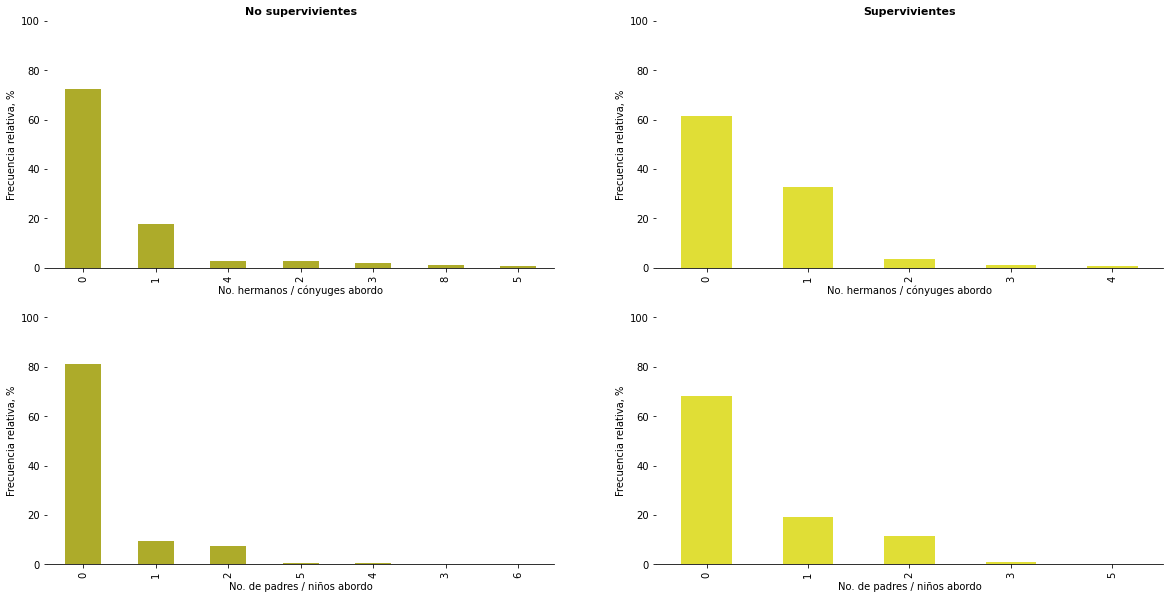

In [357]:
# Creamos un objeto de subplots y establecemos la estructura

plt.subplots(2,2, figsize=(20,10))

###############
plt.subplot(221)       

(100 * x0.value_counts() / len(x0)).plot(kind = 'bar', color = '#ADAB2A')
         
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1.set_title('No supervivientes', **title)
ax1.set_ylabel('Frecuencia relativa, %', **labels)
ax1.set_xlabel('No. hermanos / cónyuges abordo', **labels)
ax1.set_ylim(0, 100)

###############
plt.subplot(222)

(100 * x1.value_counts() / len(x1)).plot(kind = 'bar', color ='#E0DE36')
                
ax2 = plt.gca()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_title('Supervivientes', **title)
ax2.set_ylabel('Frecuencia relativa, %', **labels)
ax2.set_xlabel('No. hermanos / cónyuges abordo', **labels)
ax2.set_ylim(0, 100)

###############
plt.subplot(223) 

(100 * y0.value_counts() / len(y0)).plot(kind = 'bar', color = '#ADAB2A') 
         
ax3 = plt.gca()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('Frecuencia relativa, %', **labels)
ax3.set_xlabel('No. de padres / niños abordo', **labels)
ax3.set_ylim(0, 100)

###############
plt.subplot(224)

(100 * y1.value_counts() / len(y1)).plot(kind = 'bar', color ='#E0DE36')
                
ax4 = plt.gca()
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_ylabel('Frecuencia relativa, %', **labels)
ax4.set_xlabel('No. de padres / niños abordo', **labels)
ax4.set_ylim(0, 100)

plt.show()

**Key:** Se observa una proporción muy alta de valores 0 sobre el par de variables, y para ambas categorías. ¿Que tipo de distribución tienen estas variables? 

# **Identificación de variables: ¿Qué tipo de variables son?** 

Para poder visualizar una pequeña porción del conjunto de datos $N$, usaremos los métodos `.head` y `.tail` para imprimir las primeras y últimas 10 observaciones.

La siguienta Tabla, brinda una breve descripción de los datos en función de la información proporcionada por Kaggle, y será un punto de partida para nuestro **Análisis Exploratorio de Datos**.  

Variable | Definición | Valor 
--- | --- | --- 
`PassengerId` | ID 
`Survived` | Supervivencia | 0: No, 1 : Sí 
`Pclass` | Clase de boleto | 1: 1st, 2: 2nd, 3: 3rd
`Name` | Nombre del pasajero 
`Sex` | Género | Male, Female 
`Age` | Edad | |
`SibSp` | No. hermanos / persona abordo 
`Parch` | No. de padres / niños abordo |
`Ticket` | Número del ticket|| Cadena |
`Fare` | Tarifa del pasajero continuos |
`Cabin` | Número de cabrina string |
`Embarked` | Puerto de embarque | C: Cherbourg, Q: Queenstown, S: Southampton 

In [348]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,C


In [350]:
df.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
881,882,0,3,"Markun, Mr. Johann",0,33.0,0,0,349257,7.8958,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",1,22.0,0,0,7552,10.5167,S
883,884,0,2,"Banfield, Mr. Frederick James",0,28.0,0,0,C.A./SOTON 34068,10.5000,S
884,885,0,3,"Sutehall, Mr. Henry Jr",0,25.0,0,0,SOTON/OQ 392076,7.0500,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",1,39.0,0,5,382652,29.1250,Q
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C
890,891,0,3,"Dooley, Mr. Patrick",0,32.0,0,0,370376,7.7500,Q


In [400]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [401]:
df_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [402]:
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [404]:
df_sub.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [396]:
df_test.tail(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [345]:
print('Hay {} observaciones y {} características'.format(df.shape[0], df.shape[1]))

Hay 891 observaciones y 11 características


Variable | Tipo de variable | Tipo de dato | Categoría
--- |  --- | --- |--- | 
`PassengerId`| | ? | ?  
`Survived` | Predictiva | Cualitativo | Nominal (Dicotómico)
`Pclass` | Explicativa | Cualitativo | Ordinal 
`Name` | ? | ? | Nominal 
`Sex` | Explicativa | Cualitativo | Nominal (Dicotómica) 
`Age` | Explicativa | Cuantitativo | Continuo 
`SibSp` | ? | Cuantitativo | Discreto 
`Parch` | ? | Cuantitativa | Discreto 
`Ticket` | ? | Cualitativo | Categórica 
`Fare` | ? | Cuantitiva | Continuo 
`Cabin` | ? | Cualitativo | Nominal
`Embarked` | ? | Cualitativo | Nominal 

El **?** representa falta de certeza para determinar el tipo o categoría de la variable. 

# **Análisis univariante**

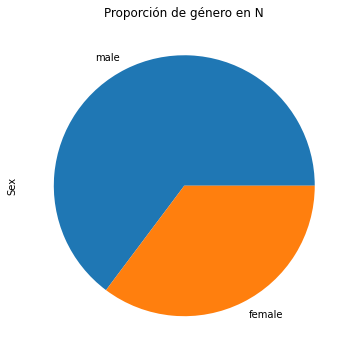

In [391]:
gender = df.Sex.value_counts() / len(df) * 100

plt.figure(figsize=(6, 6))
gender.plot(kind='pie', colormap=)

ax = plt.gca()
ax.set_title('Proporción de género en N')
plt.show()

# **Análisis bi-variante**

* Pearson's R para casos de variables continuos-continuas
* Correlation Ratio para casos de variables continuo-categórico
* Cramer's V or Theil's U para casos de variables categórico-categórico

**Planteamiento de la hipótesis nula:** 

El fin del análisis bi-variante es poder resolver la duda de: ¿Existe alguna relación entre una variable $X$ y la supervivencia? 

**$H_{o}:$** No hay dependencia entre las 2 variables categóricas.

**$H_{a}:$** Hay dependencia entre las 2 variables categóricas.

In [283]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S


In [0]:
title = {'fontsize': 11, 'weight': 'bold'}
labels = {'fontsize': 10, 'weight': 'normal'}
ticks = {'fontsize': 8, 'weight': 'normal'}

**Key:** Solo las variables `Age` y `Cabin` contienen valores nulos.

In [205]:
sex_encode = {'Sex': {"male": 0, "female": 1}}
df.replace(sex_encode, inplace=True)
df.head()
chi_sq = df[['Sex', 'Survived']]
chi_sq.head()

,Sex,Survived
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


**Paso 1:** Obtener la tabla de contigencia con la función `.crosstab` de `Pandas`.

In [206]:
# Frecuencias observaciones
obs = pd.crosstab(chi_sq.Sex , chi_sq.Survived)
obs

Survived,0,1
Sex,,
0,468,109
1,81,233


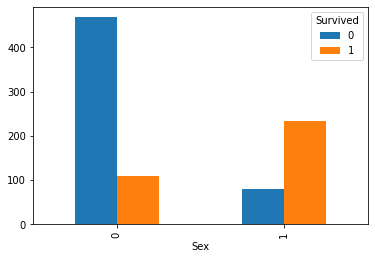

In [207]:
obs.plot(kind='bar')

**Paso 2:** Procedemos a calcular el test de ji-cuadrado usando la tabla de contigencia anterior.

In [26]:
#Chi2, p-valor, grados de libertad, frecuencia esperada
chi_2, p, dof, ex = chi2_contingency(obs)

print('Valor de ji-cuadrado: {}'.format(round(chi_2, 2)))
print('p-valor: {}'.format(p))
print('Grados de libertad: {}'.format(dof))
print('Frecuencia esperada de las observaciones: \n{}'.format(ex.round(2)))

Valor de ji-cuadrado: 263.05
p-valor: 3.711747770113424e-59
Grados de libertad: 1
Frecuencia esperada de las observaciones: 
[[355.53 221.47]
 [193.47 120.53]]


**Key:** Debido que, en la tabla de contigencia, ninguna frecuencia esperada es menor a 5, se puede realizar la prueba sin corrección de Yates

**Paso 3:** Calculamos el valor de menor probabilidad de la cola Q.

In [209]:
alpha = 0.01 # p-value
cv = chi2.ppf(q= 1-alpha, df= dof)
print('Valor crítico o probabilidad menor de la cola:', cv)

Valor crítico o probabilidad menor de la cola: 6.6348966010212145


**Paso 4:** Se realiza la comparación entre los estadísticos para rechazar o tener la hipótesis nula planteada.

In [210]:
print('Test de independencia entre variables')
if chi_2 >= cv:
  print('- Se rechaza Ho, existe relación entre las 2 variables categóricas.')
else:
  print('- Se retiene Ho, no existe relación entre las 2 variables categóricas')

print('\nTest de significación')
if p <= alpha:
  print('- Se rechaza Ho, existe relación entre las 2 variables categóricas')
else:
  print('- Se retiene Ho, no existe relación entre las 2 variables categóricas')

Test de independencia entre variables
- Se rechaza Ho, existe relación entre las 2 variables categóricas.

Test de significación
- Se rechaza Ho, existe relación entre las 2 variables categóricas


In [0]:
def chi_square(x, y, alpha=0.05):

  obs = pd.crosstab(x, y)
  chi, p, dof, ex = chi2_contingency(obs)
  cv = chi2.ppf(q= 1-alpha, df= dof)

  return (chi, p, cv)

def cramers_v(x, y):

  obs = pd.crosstab(x,y)
  chi, p, dof, ex = chi2_contingency(obs)
  n = obs.values.sum()
  r, k = obs.shape
  phi2 = chi / n
  phi2corr = max(0, phi2 - ((k-1) * (r-1)) / (n-1))
  rcorr = r - ((r-1)**2 / (n-1))
  kcorr = k - ((k-1)**2 / (n-1))
  
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def theils_u(x, y):
  
  s_xy = conditional_entropy(x, y)
  x_counter = Counter(x)
  total_occurrences = sum(x_counter.values())
  p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
  s_x = ss.entropy(p_x)
  if s_x == 0:
    return 1
  else:
    return (s_x - s_xy) / s_x

In [200]:
cramers_v(df.Sex, df.Survived)

0.5401999468101071

In [352]:
tau, p = stats.kendalltau(df.Sex, df.Survived)

print('Valor de Kendall Tau-b: {}'.format(round(tau, 2)))
print('p-valor: {}'.format(p))

Valor de Kendall Tau-b: 0.54
p-valor: 4.304562532205025e-59


# **Tratamiento de valores nulos**

Se observa que el conjunto de datos $N$ tiene $n: 891$ observaciones y $p: 12$ características, sin embargo ¿Cuántas de estas observaciones están perdidas por los valores nulos? 

In [441]:
print('Proporción Absoluta:\n')
print(df.isnull().sum())
print('\nProporción Relativa:\n')
print(df.isnull().sum() * 100 / len(df))

print('Proporción Absoluta Test:\n')
print(df2.isnull().sum())
print('\nProporción Relativa Test:\n')
print(df2.isnull().sum() * 100 / len(df2))

Proporción Absoluta:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Proporción Relativa:

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
Proporción Absoluta Test:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

Proporción Relativa Test:

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age

**Visualización**

A continuación, se observará gráficamente como se comporta la proporción en función del género. 

In [444]:
spines_off = ['top', 'bottom', 'right']
for i in spines_off:
  ax.(i)
  

top
bottom
right


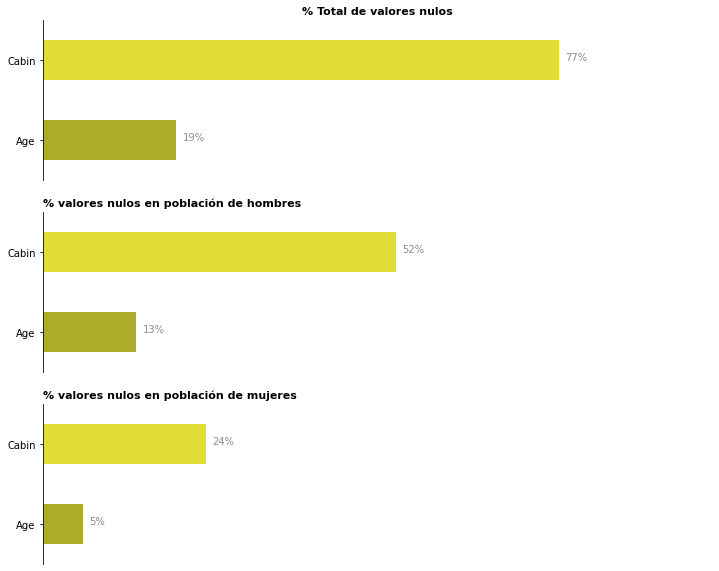

In [447]:
plt.subplots(3,1, figsize=(12,10))

###############
plt.subplot(311)

graph = 100 * df[['Age', 'Cabin']].isnull().sum() / len(df)

graph.plot(kind= 'barh', color = ['#ADAB2A', '#E0DE36'])

ax = plt.gca()

spines_off = ['top', 'bottom', 'right']
for i in spines_off:
  ax.spines[i].set_visible(False)
   
ax.set_title('% Total de valores nulos', **title)
ax.set_xlim(0, 100)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

for i, j in enumerate(graph):
  ax.text(j + 1, i, '{}%'.format(int(j)), color= '#8C8C8C', **labels)

###############
plt.subplot(312)

graph = 100 * df.loc[df.Sex == 'male', ['Age', 'Cabin']].isnull().sum() / len(df)

graph.plot(kind= 'barh', color = ['#ADAB2A', '#E0DE36'])

ax = plt.gca()

for i in spines_off:
  ax.spines[i].set_visible(False)

ax.set_title('% valores nulos en población de hombres', loc='left', **title)
ax.set_xlim(0, 100)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

for i, j in enumerate(graph):
  ax.text(j + 1, i, '{}%'.format(int(j)), color= '#8C8C8C', **labels)

###############
plt.subplot(313)

graph = 100 * df.loc[df.Sex == 'female', ['Age', 'Cabin']].isnull().sum() / len(df)

graph.plot(kind= 'barh', color = ['#ADAB2A', '#E0DE36'])
     
ax = plt.gca()

for i in spines_off:
  ax.spines[i].set_visible(False)

ax.set_title('% valores nulos en población de mujeres', loc='left', **title)
ax.set_xlim(0, 100)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

for i, j in enumerate(graph):
  ax.text(j + 1, i, '{}%'.format(int(j)), color= '#8C8C8C', **labels)

plt.show()

Se observa que la proporción de nulos en $N$ así como en los subconjuntos $N_{m}$ y $N_{h}$ se cumple la siguiente inecuación: 

$Cabin > Age > Embarked$

Considerando que la proporción de `Cabin` es relevante, ¿Qué estrategia se puede utilizar?

## **Una retrospectiva sobre Cabin**

**¿Como se distribuían las cabinas en el Titanic?**

![Plano Transversal del Titanic](https://upload.wikimedia.org/wikipedia/commons/8/84/Titanic_cutaway_diagram.png)

**Embarked**



> "*Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was ravelling in first class with her maid Amelie Icard. She occupied cabin B-28.*"



# **Random Forest**